In [1]:
# import event simulation files
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math
import matplotlib.pyplot as plt
import csv

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import snntorch as snn
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
import snntorch.functional as SF

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Selected device is',device)

Selected device is cpu


/home/andrea/anaconda3/envs/torch/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449229234/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Data processing

In [3]:
n_evt = 100000
n_evt_test = 5000
n_evt_val = 10000

evt_arr,      muon_list,      max_n      = ge.generate_noisy_evts(n_evt,      noise_frac=0.5, bkg_frac=0.3)
evt_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(n_evt_test, noise_frac=0.5, bkg_frac=0.3)
evt_arr_val,  muon_list_val,  max_n_val  = ge.generate_noisy_evts(n_evt_val,  noise_frac=0.5, bkg_frac=0.3)

100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1191.24it/s]


In [4]:
# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype, features):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return torch.tensor(padded_array)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
mu_arr      = convert_to(muon_list,      size=max_n,      target_dtype=np.float32, features=feature_list)
mu_arr_test = convert_to(muon_list_test, size=max_n_test, target_dtype=np.float32, features=feature_list)
mu_arr_val  = convert_to(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

In [5]:
def custom_spikegen(data, num_step=40, batch_size=100, linearise=True):

    spike_data = torch.zeros(size=(num_step, batch_size, ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    for n_batch, evt in enumerate(data):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                spike_data[bx-t0+ps.bx_oot, n_batch, layer-1, wire-1] = 1
            else:
                break
    if linearise:
        spike_data = spike_data.view(num_step, batch_size, -1)
                
    return spike_data    

In [6]:
def gen_target_chamber(muon_list):
    target = np.zeros(shape=(len(muon_list)))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            if hit['signal'] == True:
                target[i] = 1
                break

    return torch.tensor(target, dtype=torch.long)

In [7]:
def filter_noise(muon_list):
    target_list=[]
    
    for event in muon_list:
        target_event=[]
        for hit in event:
            
            if hit["signal"] == True:
                target_event.append(hit)
        
        target_list.append(target_event)
        
    return target_list

def gen_target_timing(muon_list, size, target_dtype, features):
    filtered_list = filter_noise(muon_list)
    return convert_to(filtered_list, size, target_dtype, features)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.data = list(zip(input_data, target))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


# Transformations

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    if type(input_variable) != torch.Tensor:
        input_variable = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = input_variable.to(target_dtype)
    
    return tensor


transform = transforms.Compose([
    lambda x: (to_tensor_and_dtype(x[0], target_dtype=torch.float32), x[1])
])

In [9]:
target      = gen_target_chamber(muon_list)
target_test = gen_target_chamber(muon_list_test)
target_val  = gen_target_chamber(muon_list_val)

train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=nw)

100000it [00:00, 1457813.37it/s]
5000it [00:00, 1434931.24it/s]
10000it [00:00, 1562589.97it/s]


## Network definitions

In [10]:
# Network Architecture 1
num_inputs1 = ps.NLAYERS*ps.NWIRES
num_hidden1 = 100
num_outputs_chamber1 = 2

num_steps1 = 40
beta1 = 0.8
threshold1=0.9

# Network Architecture 2
num_inputs2 = ps.NLAYERS*ps.NWIRES
num_hidden2 = [20,20,20]
num_outputs_chamber2 = 2

num_steps2 = 40
beta2 = 0.8
alpha2 =0.8
threshold2=0.9

# Network Architecture 3
num_inputs3 = ps.NLAYERS*ps.NWIRES
num_hidden3 = 30
num_outputs_chamber3 = 2

num_steps3 = 40
beta3 = 0.8
threshold3=0.9

# Network Architecture 4
num_inputs4 = ps.NLAYERS*ps.NWIRES
num_hidden4 = 100
num_outputs_chamber4 = 2

num_steps4 = 40
beta4 = 0.5
threshold4=0.9

# Network Architecture 5
num_inputs5 = ps.NLAYERS*ps.NWIRES
num_hidden5 = 100
num_outputs_chamber5 = 2

num_steps5 = 40
beta5 = 0.8
alpha5 =0.8
threshold5=0.9

# Network Architecture 6
num_inputs6 = ps.NLAYERS*ps.NWIRES
num_hidden6 = 30
num_outputs_chamber6 = 2

num_steps6 = 40
beta6 = 0.5
threshold6=0.9

In [11]:
class Net1layer(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps,learnable):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta1,spike_grad=spike_grad,threshold=threshold1,
                                learn_beta=learnable,learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta1,spike_grad=spike_grad,threshold=threshold1,
                                learn_beta=learnable,learn_threshold=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [12]:
class Net1layer2ndOrder(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps,learnable):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=beta1,alpha=alpha5,threshold=threshold1,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta1,alpha=alpha5,threshold=threshold1,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [13]:
class Net3layers(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps,learnable):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden[0])
        self.lif_in = snn.Synaptic(beta=beta2,alpha=alpha2,
                                   spike_grad=spike_grad,
                                   threshold=threshold2,
                                  learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_hidden1 = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden1 = snn.Synaptic(beta=beta2,alpha=alpha2,
                                    spike_grad=spike_grad,
                                    threshold=threshold2,
                                       learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_hidden2 = nn.Linear(in_features=self.hidden[1], out_features=self.hidden[2])
        self.lif_hidden2 = snn.Synaptic(beta=beta2,alpha=alpha2,
                                    spike_grad=spike_grad,
                                    threshold=threshold2,
                                       learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden[2], out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta2,alpha=alpha2,
                                    spike_grad=spike_grad,
                                    threshold=threshold2,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        synh1, memh1 = self.lif_hidden1.init_synaptic()
        synh2, memh2 = self.lif_hidden2.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            curh1 = self.fc_hidden1(spk1)
            spkh1, synh1, memh1 = self.lif_hidden1(curh1, synh1, memh1)
            
            curh2 = self.fc_hidden2(spkh1)
            spkh2, synh2, memh2 = self.lif_hidden2(curh2, synh2, memh2)
            
            cur2 = self.fc_out(spkh2)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

## Training

In [14]:
def comp_accuracy(output, targets, type):
    total = 0
    correct = 0

    # whole chamber classification
    if type == 'chamber':
        _, predicted = output.sum(dim=0).max(1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()

    # cell-by-cell classification
    elif type == 'cell':
        batch_size = targets.size(0)
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        total = targets.numel()
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for cell-by-cell classification
    elif type == 'cell_per_evt':
        batch_size = targets.size(0)
        total = batch_size
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        for i in range(batch_size):
            correct += torch.sum((predicted[i] == targets[i]).all())

    # accuracy cell-by-cell moment-bymoment for precise timing recontruction
    elif type == 'mse_timing':
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        correct = (output == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    elif type == 'mse_timing_per_evt':
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = batch_size
        for i in range(batch_size):
            correct += torch.sum((output[:, i] == targets[:, i]).all())

    elif type == "ce_timing":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        correct = (predicted == targets).sum().item()

    elif type == "bce_timing":
        total = targets.numel()
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        correct = (predicted == targets).sum().item()


    return total, correct

In [15]:
def accuracy_set(net, data_loader, loss_fn, accuracy_type, batch_size, timing, linearise, use_membrane,num_steps=40):
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr = comp_accuracy(output, targets, accuracy_type)
            total += tot
            correct += corr

        mean_loss = np.mean(temp_loss)
        acc = correct/total
        return mean_loss, acc

In [16]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, accuracy_type, 
              batch_size, num_steps = 40,linearise=True, timing=False, use_membrane=False):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val = accuracy_set(net, val_loader, loss_fn, accuracy_type,
                                              batch_size, timing, linearise, use_membrane)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

In [19]:
net1 = Net1layer(num_inputs1, num_hidden1, num_outputs_chamber1, num_steps1,False).to(device)

loss_fn1 = SF.ce_count_loss()
optimizer1 = torch.optim.Adam(net1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist1, loss_val_hist1, acc_val_hist1 = train_net(net1,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn1, optimizer1,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.603691041469574 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.5616677403450012 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.5181654095649719 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.43556898832321167 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.29385095834732056 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.2944188714027405 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.2295561283826828 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.23062589764595032 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.18247289955615997 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.2445167750120163 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.22793906927108765 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.12961502373218536 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.1475003957748413 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.15404435992240906 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.17662307620048523 

Epoch: 

Validation Set Loss: 0.0793832048214972
Validation Set Accuracy: 97.15%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.1023850366473198 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.03461407124996185 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.10399988293647766 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.051685504615306854 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.06276547163724899 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.0226045660674572 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.06068168953061104 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.06698653846979141 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.08911087363958359 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.1024903878569603 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.06066817417740822 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.19671621918678284 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.18411916494369507 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.0770

In [20]:
net2 = Net3layers(num_inputs2, num_hidden2, num_outputs_chamber2, num_steps2,False).to(device)

loss_fn2 = SF.ce_count_loss()
optimizer2 = torch.optim.Adam(net2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist2, loss_val_hist2, acc_val_hist2 = train_net(net2,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn2, optimizer2,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 14.020000457763672 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.5168617367744446 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.5321102142333984 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.23962005972862244 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.3023524582386017 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.1796003133058548 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.18590925633907318 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.2880627512931824 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.10697045177221298 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.10334514826536179 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.1315086930990219 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.1622011363506317 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.10833688080310822 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.14529256522655487 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.18114539980888367 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.10554197430610657 

Epoch:

Validation Set Loss: 0.0689712058007717
Validation Set Accuracy: 97.66%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.15223008394241333 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.10501428693532944 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.03365070000290871 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.05559493228793144 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.1165357232093811 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.10658018290996552 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.02751385048031807 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.116592176258564 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.07788877934217453 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.05873194709420204 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.17694732546806335 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.10450583696365356 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.03967702016234398 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.05294

In [21]:
net3 = Net1layer(num_inputs3, num_hidden3, num_outputs_chamber3, num_steps3,False).to(device)

loss_fn3 = SF.ce_count_loss()
optimizer3 = torch.optim.Adam(net3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist3, loss_val_hist3, acc_val_hist3 = train_net(net3,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn3, optimizer3,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 3.7672481536865234 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 1.1661655902862549 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6955495476722717 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6931473016738892 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6931473016738892 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.6931473016738892 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.6931473016738892 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.6127476692199707 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.4853184223175049 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.4918985068798065 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.4046633243560791 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.4818681478500366 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.37523019313812256 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.3194390535354614 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.33090364933013916 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.29796457290649414 

Epoch: 0
Ba

Validation Set Loss: 0.13146877579391003
Validation Set Accuracy: 93.73%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.14367163181304932 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.16606485843658447 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.12324211001396179 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.19906753301620483 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.18258148431777954 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.10609965026378632 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.0992853194475174 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.09490080177783966 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.19701549410820007 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.13821150362491608 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.18379633128643036 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.11200696974992752 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.19376607239246368 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.12

In [22]:
net4 = Net1layer(num_inputs4, num_hidden4, num_outputs_chamber4, num_steps4,False).to(device)

loss_fn4 = SF.ce_count_loss()
optimizer4 = torch.optim.Adam(net4.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist4, loss_val_hist4, acc_val_hist4 = train_net(net4,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn4, optimizer4,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6893484592437744 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.47856399416923523 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.38260528445243835 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.37044575810432434 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.40002793073654175 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.3896218240261078 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.30354776978492737 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.1800614595413208 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.2154446542263031 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.15380556881427765 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.30567577481269836 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.2537976801395416 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.1253059357404709 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.1309252381324768 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.2809586226940155 

Epoch: 

Validation Set Loss: 0.076435023304075
Validation Set Accuracy: 97.65%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.06578845530748367 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.10784540325403214 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.07501043379306793 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.039478886872529984 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.11226760596036911 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.048841819167137146 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.08566443622112274 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.08147668838500977 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.08712096512317657 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.07964477688074112 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.04971366375684738 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.04229477047920227 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.09800506383180618 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.0

In [23]:
net5 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,False).to(device)

loss_fn5 = SF.ce_count_loss()
optimizer5 = torch.optim.Adam(net5.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist5, loss_val_hist5, acc_val_hist5 = train_net(net5,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn5, optimizer5,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 4.710000038146973 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6931473016738892 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6931473016738892 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6931473016738892 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.6855496168136597 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.47256237268447876 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.4046775698661804 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.3182893991470337 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.3230849504470825 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.32483336329460144 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.27810847759246826 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.2055777609348297 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.30777525901794434 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.12776301801204681 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.1530085802078247 

Epoch: 0
B

Epoch: 5
Batch: 950
Iteration: 5950
Loss: 0.01596090942621231 

Validation Set Loss: 0.04608606021851301
Validation Set Accuracy: 98.55%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.05284525454044342 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.024666421115398407 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.08824357390403748 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.032460350543260574 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.08985355496406555 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.03545225039124489 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.08053582161664963 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.022493405267596245 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.04311174526810646 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.050845738500356674 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.06651571393013 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.05491811782121658 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.

In [24]:
net6 = Net1layer(num_inputs1, num_hidden1, num_outputs_chamber1, num_steps1,True).to(device)

loss_fn6 = SF.ce_count_loss()
optimizer6 = torch.optim.Adam(net6.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist6, loss_val_hist6, acc_val_hist6 = train_net(net6,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn6, optimizer6,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.5581009984016418 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.5163578391075134 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.42381393909454346 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.4862625002861023 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.4090777635574341 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.2691788077354431 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.2546139061450958 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.11322126537561417 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.1860344111919403 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.11841793358325958 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.1407788097858429 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.1902838498353958 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.15040276944637299 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.14316192269325256 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.0999751091003418 

Epoch: 0


Validation Set Loss: 0.0587910529691726
Validation Set Accuracy: 98.06%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.054648399353027344 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.03997582569718361 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.04546060413122177 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.04625515639781952 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.04259682074189186 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.09465255588293076 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.16865873336791992 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.02130199410021305 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.0405193530023098 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.1347963958978653 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.033611197024583817 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.04071611911058426 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.04285844787955284 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.05

In [25]:
net7 = Net3layers(num_inputs2, num_hidden2, num_outputs_chamber2, num_steps2,True).to(device)

loss_fn7 = SF.ce_count_loss()
optimizer7 = torch.optim.Adam(net7.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7, loss_val_hist7, acc_val_hist7 = train_net(net7,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn7, optimizer7,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 14.3100004196167 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6931473016738892 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6931473016738892 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6931473016738892 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.6893483996391296 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.4638884365558624 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.3725687861442566 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.3896578252315521 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.35376662015914917 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.3534044027328491 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.37328678369522095 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.25110453367233276 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.2609623968601227 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.27219438552856445 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.2889466881752014 

Epoch: 0
Bat

Validation Set Loss: 0.05261226328089833
Validation Set Accuracy: 97.87%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.06453969329595566 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.060947857797145844 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.07107209414243698 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.02233877405524254 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.06823357939720154 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.05587668716907501 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.03098234161734581 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.026074109598994255 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.010549545288085938 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.02122090384364128 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.0536801852285862 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.04194769263267517 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.08415531367063522 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0

In [26]:
net8 = Net1layer(num_inputs3, num_hidden3, num_outputs_chamber3, num_steps3,True).to(device)

loss_fn8 = SF.ce_count_loss()
optimizer8 = torch.optim.Adam(net8.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist8, loss_val_hist8, acc_val_hist8 = train_net(net8,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn8, optimizer8,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.587273359298706 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.5654821991920471 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.5019458532333374 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.517900824546814 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.5120605826377869 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.3379940688610077 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.2723831832408905 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.28803569078445435 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.2587067484855652 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.26127853989601135 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.31588396430015564 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.25197461247444153 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.27059054374694824 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.22614826261997223 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.21396902203559875 

Epoch: 0


Validation Set Loss: 0.08590097334235906
Validation Set Accuracy: 96.71%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.08233220875263214 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.07076264172792435 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.10123536735773087 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.05021292343735695 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.07955845445394516 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.15105536580085754 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.09081696718931198 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.11825772374868393 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.046553097665309906 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.06386882066726685 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.09528007358312607 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.07928671687841415 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.17953553795814514 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.

In [27]:
net9 = Net1layer(num_inputs4, num_hidden4, num_outputs_chamber4, num_steps4,True).to(device)

loss_fn9 = SF.ce_count_loss()
optimizer9 = torch.optim.Adam(net9.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist9, loss_val_hist9, acc_val_hist9 = train_net(net9,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn9, optimizer9,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6855495572090149 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6248132586479187 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.4344869554042816 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.38220351934432983 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.3108958601951599 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.31077897548675537 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.26642853021621704 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.17152227461338043 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.1413055658340454 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.14909003674983978 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.2831612229347229 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.18200552463531494 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.14354553818702698 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.07412058115005493 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.10545028746128082 

Epoch

Epoch: 5
Batch: 950
Iteration: 5950
Loss: 0.07099796086549759 

Validation Set Loss: 0.05654004246462137
Validation Set Accuracy: 98.30%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.10181392729282379 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.016958588734269142 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.05181977152824402 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.06544534862041473 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.06152992695569992 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.022693295031785965 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.07209306210279465 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.1460564285516739 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.05404242128133774 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.09424856305122375 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.04688035324215889 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.04659649357199669 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.

In [28]:
net10 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,True).to(device)

loss_fn10 = SF.ce_count_loss()
optimizer10 = torch.optim.Adam(net10.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10, loss_val_hist10, acc_val_hist10 = train_net(net10,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn10, optimizer10,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 7.579999923706055 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6931473016738892 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6931473016738892 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6931473016738892 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.6931473016738892 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.6931473016738892 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.6931473016738892 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.6931473016738892 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.6931473016738892 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.5007847547531128 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.34159281849861145 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.3192526400089264 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.26392054557800293 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.3370673358440399 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.2850115895271301 

Epoch: 0
Batc

Epoch: 5
Batch: 950
Iteration: 5950
Loss: 0.09783560037612915 

Validation Set Loss: 0.06734667023643852
Validation Set Accuracy: 96.59%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.06781689822673798 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.02075466886162758 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.05709526687860489 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.014396519400179386 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.07638762146234512 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.08994816988706589 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.02819724753499031 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.043002232909202576 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.026718251407146454 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.07802219688892365 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.21552345156669617 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.10204853117465973 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 

In [35]:
net11 = Net1layer(num_inputs6, num_hidden6, num_outputs_chamber6, num_steps6,False).to(device)

loss_fn11 = SF.ce_count_loss()
optimizer11 = torch.optim.Adam(net11.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist11, loss_val_hist11, acc_val_hist11 = train_net(net11,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn11, optimizer11,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6893483996391296 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.5616574883460999 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.5494397282600403 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.4814378619194031 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.4725678265094757 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.5341503024101257 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.3879562318325043 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.28616124391555786 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.255296915769577 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.3403865396976471 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.23395352065563202 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.3057292103767395 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.18843671679496765 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.20342592895030975 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.219535231590271 

Epoch: 0
Bat

Validation Set Loss: 0.14348734851926565
Validation Set Accuracy: 93.24%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.2025185525417328 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.13830530643463135 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.10162986069917679 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.15455983579158783 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.18099576234817505 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.1913144439458847 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.13530030846595764 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.12412653118371964 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.24140968918800354 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.1808561533689499 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.17109474539756775 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.12621396780014038 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.1826542615890503 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.06663

In [32]:
net12 = Net1layer(num_inputs6, num_hidden6, num_outputs_chamber6, num_steps6,True).to(device)

loss_fn12 = SF.ce_count_loss()
optimizer12 = torch.optim.Adam(net12.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist12, loss_val_hist12, acc_val_hist12 = train_net(net12,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn12, optimizer12,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.5056002736091614 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.5902108550071716 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.4887765645980835 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.34536853432655334 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.40374383330345154 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.37621113657951355 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.3626399636268616 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.2985056936740875 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.21435600519180298 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.279743492603302 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.2743247449398041 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.2827349305152893 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.18506357073783875 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.18994520604610443 

Epoch: 0


Validation Set Loss: 0.08634436568245292
Validation Set Accuracy: 96.40%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.1211286336183548 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.07039706408977509 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.09469158202409744 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.04821949824690819 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.07567079365253448 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.07811761647462845 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.11153428256511688 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.10206563025712967 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.12437329441308975 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.08028972893953323 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.1207452192902565 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.09222161024808884 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.09263511747121811 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.071

In [48]:
for i in range(1,13):
    csv_file_path = f'results/batch_size{batch_size}/output{i}.csv'
    
    loss_train = globals().get(f'loss_hist{i}')
    loss_val = globals().get(f'loss_val_hist{i}')
    acc = globals().get(f'acc_val_hist{i}')
    
    max_length = max(len(loss_train), len(loss_val), len(acc))

    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')


CSV file "results/batch_size100/output1.csv" created successfully.
CSV file "results/batch_size100/output2.csv" created successfully.
CSV file "results/batch_size100/output3.csv" created successfully.
CSV file "results/batch_size100/output4.csv" created successfully.
CSV file "results/batch_size100/output5.csv" created successfully.
CSV file "results/batch_size100/output6.csv" created successfully.
CSV file "results/batch_size100/output7.csv" created successfully.
CSV file "results/batch_size100/output8.csv" created successfully.
CSV file "results/batch_size100/output9.csv" created successfully.
CSV file "results/batch_size100/output10.csv" created successfully.
CSV file "results/batch_size100/output11.csv" created successfully.
CSV file "results/batch_size100/output12.csv" created successfully.


### Results

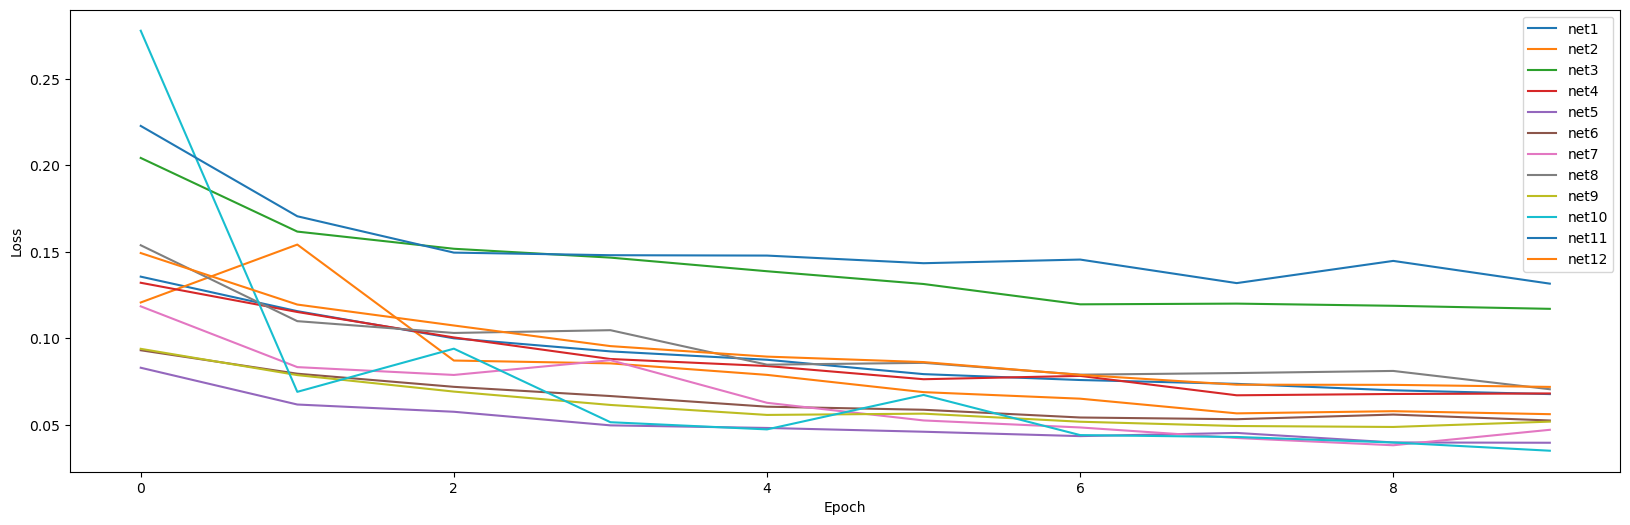

Results after 10 epochs:

Position 1: net10 - loss = 0.035
Position 2: net5 - loss = 0.04
Position 3: net7 - loss = 0.047
Position 4: net9 - loss = 0.052
Position 5: net6 - loss = 0.053
Position 6: net2 - loss = 0.056
Position 7: net1 - loss = 0.068
Position 8: net4 - loss = 0.068
Position 9: net8 - loss = 0.071
Position 10: net12 - loss = 0.072
Position 11: net3 - loss = 0.117
Position 12: net11 - loss = 0.132


In [47]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist1,label='net1')
plt.plot(loss_val_hist2,label='net2')
plt.plot(loss_val_hist3,label='net3')
plt.plot(loss_val_hist4,label='net4')
plt.plot(loss_val_hist5,label='net5')
plt.plot(loss_val_hist6,label='net6')
plt.plot(loss_val_hist7,label='net7')
plt.plot(loss_val_hist8,label='net8')
plt.plot(loss_val_hist9,label='net9')
plt.plot(loss_val_hist10,label='net10')
plt.plot(loss_val_hist11,label='net11')
plt.plot(loss_val_hist12,label='net12')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,13):
    
    loss_val = globals().get(f'loss_val_hist{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

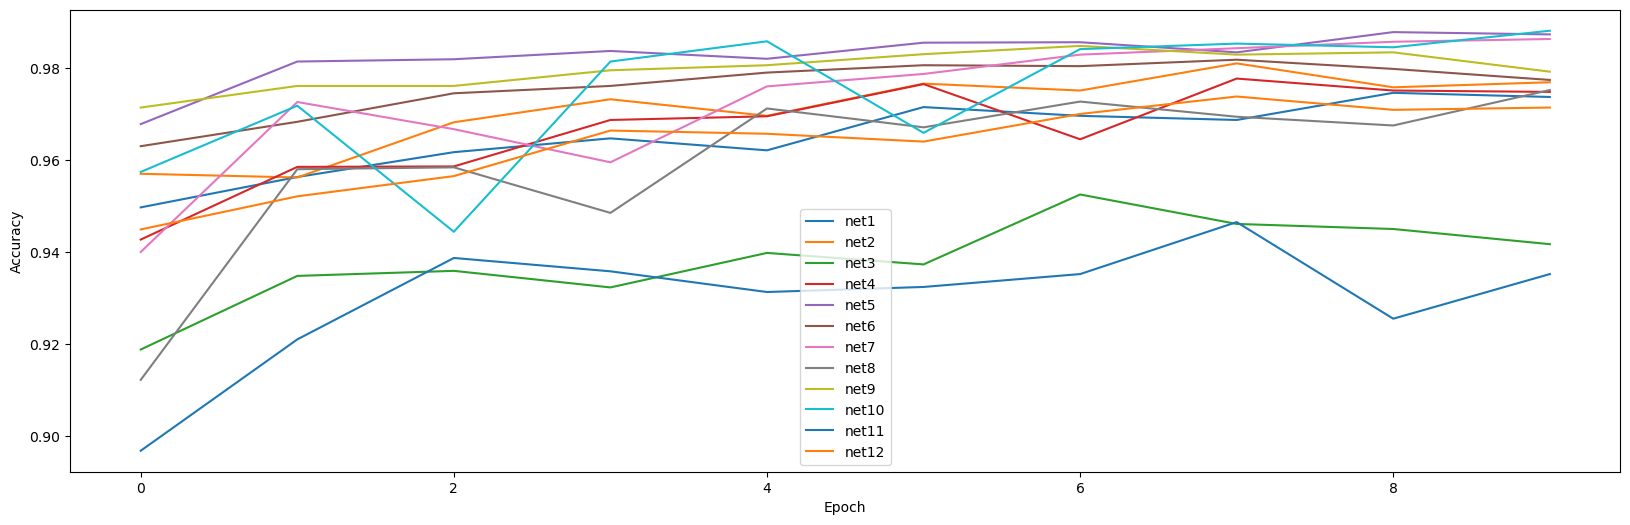

Results after 10 epochs:

Position 1: net10 - loss = 98.81%
Position 2: net5 - loss = 98.73%
Position 3: net7 - loss = 98.63%
Position 4: net9 - loss = 97.92%
Position 5: net6 - loss = 97.74%
Position 6: net2 - loss = 97.69%
Position 7: net8 - loss = 97.52%
Position 8: net4 - loss = 97.48%
Position 9: net1 - loss = 97.37%
Position 10: net12 - loss = 97.14%
Position 11: net3 - loss = 94.17%
Position 12: net11 - loss = 93.52%


In [46]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist1,label='net1')
plt.plot(acc_val_hist2,label='net2')
plt.plot(acc_val_hist3,label='net3')
plt.plot(acc_val_hist4,label='net4')
plt.plot(acc_val_hist5,label='net5')
plt.plot(acc_val_hist6,label='net6')
plt.plot(acc_val_hist7,label='net7')
plt.plot(acc_val_hist8,label='net8')
plt.plot(acc_val_hist9,label='net9')
plt.plot(acc_val_hist10,label='net10')
plt.plot(acc_val_hist11,label='net11')
plt.plot(acc_val_hist12,label='net12')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,13):
    
    acc_val = globals().get(f'acc_val_hist{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(acc_value*100,3)}%')

### Batch analysis

In [49]:
batch_size1 = 50
batch_size2 = 100
batch_size3 = 2000
nw=0

train_loader1 = DataLoader(train_dataset, batch_size=batch_size1, shuffle=True, num_workers=nw)
test_loader1  = DataLoader(test_dataset,  batch_size=batch_size1, shuffle=False, num_workers=nw)
val_loader1   = DataLoader(val_dataset,   batch_size=batch_size1, shuffle=False, num_workers=nw)

train_loader2 = DataLoader(train_dataset, batch_size=batch_size2, shuffle=True, num_workers=nw)
test_loader2  = DataLoader(test_dataset,  batch_size=batch_size2, shuffle=False, num_workers=nw)
val_loader2   = DataLoader(val_dataset,   batch_size=batch_size2, shuffle=False, num_workers=nw)

train_loader3 = DataLoader(train_dataset, batch_size=batch_size3, shuffle=True, num_workers=nw)
test_loader3  = DataLoader(test_dataset,  batch_size=batch_size3, shuffle=False, num_workers=nw)
val_loader3   = DataLoader(val_dataset,   batch_size=batch_size3, shuffle=False, num_workers=nw)

#### Net7

In [58]:
net7_batch1 = Net3layers(num_inputs2, num_hidden2, num_outputs_chamber2, num_steps2,True).to(device)

loss_fn7_batch1 = SF.ce_count_loss()
optimizer7_batch1 = torch.optim.Adam(net7_batch1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7_batch1, loss_val_hist7_batch1, acc_val_hist7_batch1 = train_net(net7_batch1,
                                                   train_loader1, val_loader1,
                                                   num_epochs, loss_fn7_batch1, optimizer7_batch1,
                                                   accuracy_type, batch_size1)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.260000228881836 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6132616400718689 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6608594655990601 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.5732616782188416 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6932618021965027 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.5732616186141968 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.6332616209983826 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.5532615780830383 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.6332616209983826 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.7132617831230164 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.5532615780830383 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.573261559009552 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.6332617402076721 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.3779626786708832 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.36114805936813354 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.35316580533981323 

Epoch: 0
Batc

Epoch: 3
Batch: 100
Iteration: 6100
Loss: 0.04982155188918114 

Epoch: 3
Batch: 150
Iteration: 6150
Loss: 0.020771272480487823 

Epoch: 3
Batch: 200
Iteration: 6200
Loss: 0.026070648804306984 

Epoch: 3
Batch: 250
Iteration: 6250
Loss: 0.13124223053455353 

Epoch: 3
Batch: 300
Iteration: 6300
Loss: 0.15175661444664001 

Epoch: 3
Batch: 350
Iteration: 6350
Loss: 0.1532973051071167 

Epoch: 3
Batch: 400
Iteration: 6400
Loss: 0.0044754017144441605 

Epoch: 3
Batch: 450
Iteration: 6450
Loss: 0.010174098424613476 

Epoch: 3
Batch: 500
Iteration: 6500
Loss: 0.07186564803123474 

Epoch: 3
Batch: 550
Iteration: 6550
Loss: 0.10474362224340439 

Epoch: 3
Batch: 600
Iteration: 6600
Loss: 0.005095813889056444 

Epoch: 3
Batch: 650
Iteration: 6650
Loss: 0.048166871070861816 

Epoch: 3
Batch: 700
Iteration: 6700
Loss: 0.03987659141421318 

Epoch: 3
Batch: 750
Iteration: 6750
Loss: 0.05349041894078255 

Epoch: 3
Batch: 800
Iteration: 6800
Loss: 0.2037247270345688 

Epoch: 3
Batch: 850
Iteration: 6850

Epoch: 6
Batch: 100
Iteration: 12100
Loss: 0.015470262616872787 

Epoch: 6
Batch: 150
Iteration: 12150
Loss: 0.04870828241109848 

Epoch: 6
Batch: 200
Iteration: 12200
Loss: 0.08861086517572403 

Epoch: 6
Batch: 250
Iteration: 12250
Loss: 0.013512537814676762 

Epoch: 6
Batch: 300
Iteration: 12300
Loss: 0.09875310957431793 

Epoch: 6
Batch: 350
Iteration: 12350
Loss: 0.0907064825296402 

Epoch: 6
Batch: 400
Iteration: 12400
Loss: 0.08101016283035278 

Epoch: 6
Batch: 450
Iteration: 12450
Loss: 0.014990696683526039 

Epoch: 6
Batch: 500
Iteration: 12500
Loss: 0.03721971437335014 

Epoch: 6
Batch: 550
Iteration: 12550
Loss: 0.07231984287500381 

Epoch: 6
Batch: 600
Iteration: 12600
Loss: 0.08717772364616394 

Epoch: 6
Batch: 650
Iteration: 12650
Loss: 0.06015770882368088 

Epoch: 6
Batch: 700
Iteration: 12700
Loss: 0.08549020439386368 

Epoch: 6
Batch: 750
Iteration: 12750
Loss: 0.013101750984787941 

Epoch: 6
Batch: 800
Iteration: 12800
Loss: 0.0076117436401546 

Epoch: 6
Batch: 850
Ite

Epoch: 9
Batch: 50
Iteration: 18050
Loss: 0.01584765501320362 

Epoch: 9
Batch: 100
Iteration: 18100
Loss: 0.1787712275981903 

Epoch: 9
Batch: 150
Iteration: 18150
Loss: 0.010058701038360596 

Epoch: 9
Batch: 200
Iteration: 18200
Loss: 0.0208321213722229 

Epoch: 9
Batch: 250
Iteration: 18250
Loss: 0.04384775087237358 

Epoch: 9
Batch: 300
Iteration: 18300
Loss: 0.18920068442821503 

Epoch: 9
Batch: 350
Iteration: 18350
Loss: 0.06815116107463837 

Epoch: 9
Batch: 400
Iteration: 18400
Loss: 0.030884545296430588 

Epoch: 9
Batch: 450
Iteration: 18450
Loss: 0.02117885835468769 

Epoch: 9
Batch: 500
Iteration: 18500
Loss: 0.03644869476556778 

Epoch: 9
Batch: 550
Iteration: 18550
Loss: 0.020586242899298668 

Epoch: 9
Batch: 600
Iteration: 18600
Loss: 0.08176569640636444 

Epoch: 9
Batch: 650
Iteration: 18650
Loss: 0.012712974101305008 

Epoch: 9
Batch: 700
Iteration: 18700
Loss: 0.015310538001358509 

Epoch: 9
Batch: 750
Iteration: 18750
Loss: 0.2082383930683136 

Epoch: 9
Batch: 800
Iter

In [59]:
net7_batch2 = Net3layers(num_inputs2, num_hidden2, num_outputs_chamber2, num_steps2,True).to(device)

loss_fn7_batch2 = SF.ce_count_loss()
optimizer7_batch2 = torch.optim.Adam(net7_batch2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7_batch2, loss_val_hist7_batch2, acc_val_hist7_batch2 = train_net(net7_batch2,
                                                   train_loader2, val_loader2,
                                                   num_epochs, loss_fn7_batch2, optimizer7_batch2,
                                                   accuracy_type, batch_size2)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 4.349999904632568 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6917506456375122 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6532615423202515 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6508593559265137 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.5570604801177979 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.6408594250679016 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.6931473016738892 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.5532615780830383 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.6372048854827881 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.6370605230331421 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.5932616591453552 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.6632617115974426 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.6108593940734863 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.5570604801177979 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.6893484592437744 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.6070604920387268 

Epoch: 0
Batch:

Validation Set Loss: 0.06793617554008961
Validation Set Accuracy: 96.91%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.034549467265605927 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.038267627358436584 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.04656977206468582 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.051945000886917114 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.04483546316623688 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.024585925042629242 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.09182780981063843 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.062290310859680176 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.09144814312458038 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.046967096626758575 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.09201264381408691 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.05656623840332031 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.04622003436088562 

Epoch: 6
Batch: 650
Iteration: 6650
Los

In [62]:
net7_batch3 = Net3layers(num_inputs2, num_hidden2, num_outputs_chamber2, num_steps2,True).to(device)

loss_fn7_batch3 = SF.ce_count_loss()
optimizer7_batch3 = torch.optim.Adam(net7_batch3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7_batch3, loss_val_hist7_batch3, acc_val_hist7_batch3 = train_net(net7_batch3,
                                                   train_loader3, val_loader3,
                                                   num_epochs, loss_fn7_batch3, optimizer7_batch3,
                                                   accuracy_type, batch_size3)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 9.357501029968262 

Validation Set Loss: 0.6931473016738892
Validation Set Accuracy: 28.94%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 50
Loss: 0.6931473016738892 

Validation Set Loss: 0.49525806307792664
Validation Set Accuracy: 76.10%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 100
Loss: 0.5081157684326172 

Validation Set Loss: 0.42753198742866516
Validation Set Accuracy: 83.65%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 150
Loss: 0.42563116550445557 

Validation Set Loss: 0.3577323853969574
Validation Set Accuracy: 89.91%

--------------------------------------------------

Epoch: 4
Batch: 0
Iteration: 200
Loss: 0.36936068534851074 

Validation Set Loss: 0.322821843624115
Validation Set Accuracy: 92.40%

--------------------------------------------------

Epoch: 5
Batch: 0
Iteration: 250
Loss: 0.33670246601104736 

Validation Set 

In [63]:
for i in range(1,4):
    csv_file_path = f'results/batch_test/output_net7_{i}.csv'
    
    loss_train = globals().get(f'loss_hist7_batch{i}')
    loss_val = globals().get(f'loss_val_hist7_batch{i}')
    acc = globals().get(f'acc_val_hist7_batch{i}')
    
    # Find the maximum length among the arrays
    max_length = max(len(loss_train), len(loss_val), len(acc))

    # Fill missing values with None
    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    # Write the data to a CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        # Write the header
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        # Write the data
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')

CSV file "results/batch_test/output_net7_1.csv" created successfully.
CSV file "results/batch_test/output_net7_2.csv" created successfully.
CSV file "results/batch_test/output_net7_3.csv" created successfully.


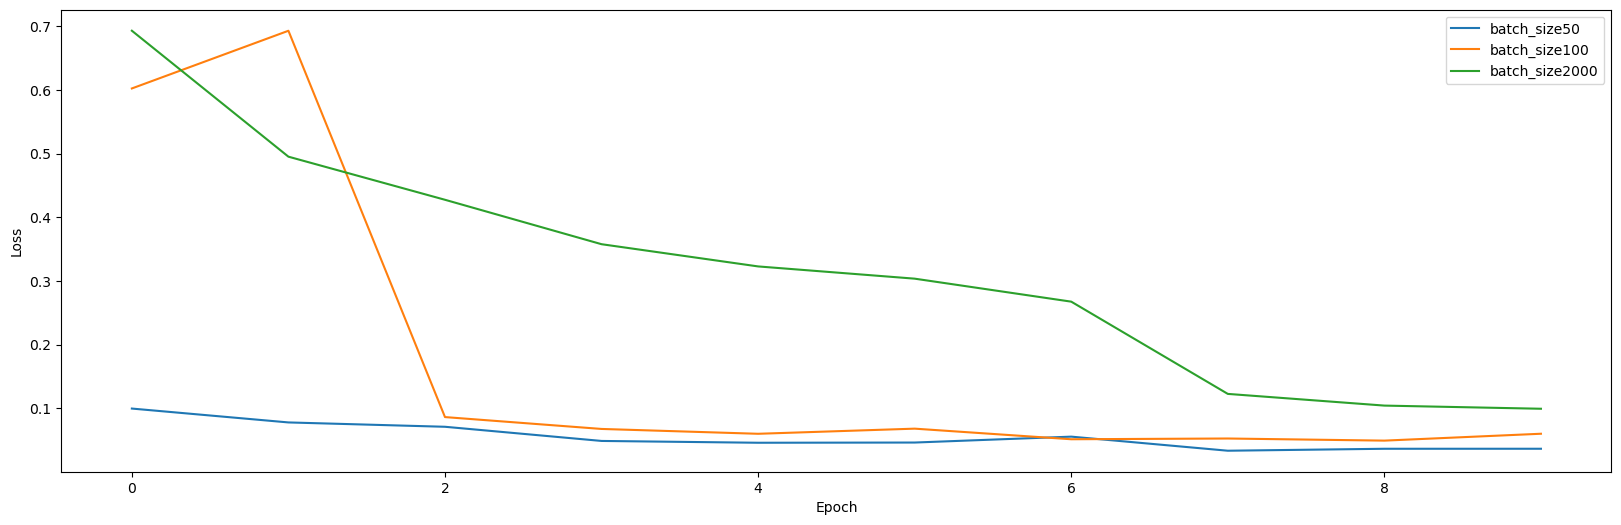

Results after 10 epochs:

Position 1: net1 - loss = 0.036
Position 2: net2 - loss = 0.06
Position 3: net3 - loss = 0.099


In [66]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist7_batch1,label='batch_size50')
plt.plot(loss_val_hist7_batch2,label='batch_size100')
plt.plot(loss_val_hist7_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,4):
    
    loss_val = globals().get(f'loss_val_hist7_batch{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

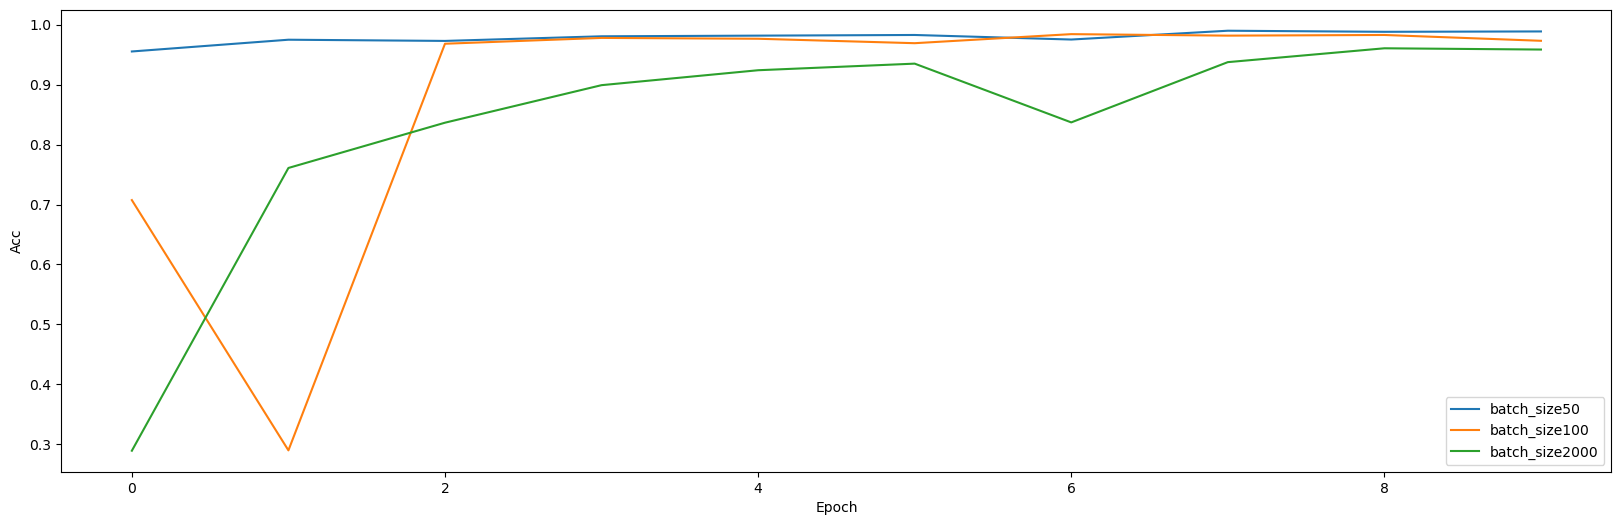

Results after 10 epochs:

Position 1: net1 - loss = 98.87%
Position 2: net2 - loss = 97.31%
Position 3: net3 - loss = 95.85%


In [73]:
# Plot Acc
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist7_batch1,label='batch_size50')
plt.plot(acc_val_hist7_batch2,label='batch_size100')
plt.plot(acc_val_hist7_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,4):
    
    acc_val = globals().get(f'acc_val_hist7_batch{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(acc_value*100,3)}%')

#### Net10

In [74]:
net10_batch1 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,True).to(device)

loss_fn10_batch1 = SF.ce_count_loss()
optimizer10_batch1 = torch.optim.Adam(net10_batch1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10_batch1, loss_val_hist10_batch1, acc_val_hist10_batch1 = train_net(net10_batch1,
                                                   train_loader1, val_loader1,
                                                   num_epochs, loss_fn10_batch1, optimizer10_batch1,
                                                   accuracy_type, batch_size1)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 1.1259527206420898 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.5684570074081421 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6560549139976501 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6436525583267212 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6684572100639343 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.6808595061302185 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.8348099589347839 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.5884570479393005 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.6903541088104248 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.6008592844009399 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.6408593654632568 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.6360547542572021 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.6532617211341858 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.6208593249320984 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.4317333996295929 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.2560105323791504 

Epoch: 0
Batch

Epoch: 3
Batch: 150
Iteration: 6150
Loss: 0.1187082976102829 

Epoch: 3
Batch: 200
Iteration: 6200
Loss: 0.10775361955165863 

Epoch: 3
Batch: 250
Iteration: 6250
Loss: 0.2596811354160309 

Epoch: 3
Batch: 300
Iteration: 6300
Loss: 0.05594850704073906 

Epoch: 3
Batch: 350
Iteration: 6350
Loss: 0.0729781836271286 

Epoch: 3
Batch: 400
Iteration: 6400
Loss: 0.05574915558099747 

Epoch: 3
Batch: 450
Iteration: 6450
Loss: 0.01773700676858425 

Epoch: 3
Batch: 500
Iteration: 6500
Loss: 0.07907183468341827 

Epoch: 3
Batch: 550
Iteration: 6550
Loss: 0.014504148624837399 

Epoch: 3
Batch: 600
Iteration: 6600
Loss: 0.09122055768966675 

Epoch: 3
Batch: 650
Iteration: 6650
Loss: 0.09400761872529984 

Epoch: 3
Batch: 700
Iteration: 6700
Loss: 0.09206604957580566 

Epoch: 3
Batch: 750
Iteration: 6750
Loss: 0.10708924382925034 

Epoch: 3
Batch: 800
Iteration: 6800
Loss: 0.01147843711078167 

Epoch: 3
Batch: 850
Iteration: 6850
Loss: 0.08707074820995331 

Epoch: 3
Batch: 900
Iteration: 6900
Loss: 

Epoch: 6
Batch: 200
Iteration: 12200
Loss: 0.028737135231494904 

Epoch: 6
Batch: 250
Iteration: 12250
Loss: 0.016463346779346466 

Epoch: 6
Batch: 300
Iteration: 12300
Loss: 0.049701057374477386 

Epoch: 6
Batch: 350
Iteration: 12350
Loss: 0.07450234144926071 

Epoch: 6
Batch: 400
Iteration: 12400
Loss: 0.007948982529342175 

Epoch: 6
Batch: 450
Iteration: 12450
Loss: 0.009466246701776981 

Epoch: 6
Batch: 500
Iteration: 12500
Loss: 0.03547713905572891 

Epoch: 6
Batch: 550
Iteration: 12550
Loss: 0.017396630719304085 

Epoch: 6
Batch: 600
Iteration: 12600
Loss: 0.09012498706579208 

Epoch: 6
Batch: 650
Iteration: 12650
Loss: 0.014440777711570263 

Epoch: 6
Batch: 700
Iteration: 12700
Loss: 0.027692681178450584 

Epoch: 6
Batch: 750
Iteration: 12750
Loss: 0.0020571232307702303 

Epoch: 6
Batch: 800
Iteration: 12800
Loss: 0.10810409486293793 

Epoch: 6
Batch: 850
Iteration: 12850
Loss: 0.023125579580664635 

Epoch: 6
Batch: 900
Iteration: 12900
Loss: 0.04626496136188507 

Epoch: 6
Batch

Epoch: 9
Batch: 150
Iteration: 18150
Loss: 0.1636088490486145 

Epoch: 9
Batch: 200
Iteration: 18200
Loss: 8.290524419862777e-05 

Epoch: 9
Batch: 250
Iteration: 18250
Loss: 0.05557432025671005 

Epoch: 9
Batch: 300
Iteration: 18300
Loss: 0.039767444133758545 

Epoch: 9
Batch: 350
Iteration: 18350
Loss: 0.060944151133298874 

Epoch: 9
Batch: 400
Iteration: 18400
Loss: 0.01362406462430954 

Epoch: 9
Batch: 450
Iteration: 18450
Loss: 0.016028830781579018 

Epoch: 9
Batch: 500
Iteration: 18500
Loss: 0.07569015026092529 

Epoch: 9
Batch: 550
Iteration: 18550
Loss: 0.06590715050697327 

Epoch: 9
Batch: 600
Iteration: 18600
Loss: 0.0024704658426344395 

Epoch: 9
Batch: 650
Iteration: 18650
Loss: 0.029035057872533798 

Epoch: 9
Batch: 700
Iteration: 18700
Loss: 0.043167103081941605 

Epoch: 9
Batch: 750
Iteration: 18750
Loss: 0.12704095244407654 

Epoch: 9
Batch: 800
Iteration: 18800
Loss: 0.0443117581307888 

Epoch: 9
Batch: 850
Iteration: 18850
Loss: 0.01606099307537079 

Epoch: 9
Batch: 90

In [85]:
net10_batch2 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,True).to(device)

loss_fn10_batch2 = SF.ce_count_loss()
optimizer10_batch2 = torch.optim.Adam(net10_batch2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10_batch2, loss_val_hist10_batch2, acc_val_hist10_batch2 = train_net(net10_batch2,
                                                   train_loader2, val_loader2,
                                                   num_epochs, loss_fn10_batch2, optimizer10_batch2,
                                                   accuracy_type, batch_size2)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 6.6309380531311035 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6931473016738892 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.674691915512085 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.5262677669525146 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.5763717889785767 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.38618072867393494 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.4635680317878723 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.38307178020477295 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.2619156241416931 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.3687964379787445 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.35983607172966003 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.30560314655303955 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.20311836898326874 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.19023920595645905 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.11694730073213577 

Epoch: 0

Epoch: 5
Batch: 950
Iteration: 5950
Loss: 0.03573231026530266 

Validation Set Loss: 0.06400947725691367
Validation Set Accuracy: 98.47%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.06445392966270447 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.09317901730537415 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.05426250398159027 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.07039801776409149 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.04596519097685814 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.02147447131574154 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.1405310183763504 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.126967191696167 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.1577487587928772 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.008493990637362003 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.018351558595895767 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.10899357497692108 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.045

In [86]:
net10_batch3 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,True).to(device)

loss_fn10_batch3 = SF.ce_count_loss()
optimizer10_batch3 = torch.optim.Adam(net10_batch3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10_batch3, loss_val_hist10_batch3, acc_val_hist10_batch3 = train_net(net10,
                                                   train_loader3, val_loader3,
                                                   num_epochs, loss_fn10_batch3, optimizer10_batch3,
                                                   accuracy_type, batch_size3)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.031946778297424316 

Validation Set Loss: 0.03531120605766773
Validation Set Accuracy: 98.83%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 50
Loss: 0.03511382266879082 

Validation Set Loss: 0.03531120605766773
Validation Set Accuracy: 98.83%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 100
Loss: 0.05304011330008507 

Validation Set Loss: 0.03531120605766773
Validation Set Accuracy: 98.83%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 150
Loss: 0.041016481816768646 

Validation Set Loss: 0.03531120605766773
Validation Set Accuracy: 98.83%

--------------------------------------------------

Epoch: 4
Batch: 0
Iteration: 200
Loss: 0.04393592104315758 

Validation Set Loss: 0.03531120605766773
Validation Set Accuracy: 98.83%

--------------------------------------------------

Epoch: 5
Batch: 0
Iteration: 250
Loss: 0.05489781126379967 

Valid

In [87]:
for i in range(1,4):
    csv_file_path = f'results/batch_test/output_net10_{i}.csv'
    
    loss_train = globals().get(f'loss_hist10_batch{i}')
    loss_val = globals().get(f'loss_val_hist10_batch{i}')
    acc = globals().get(f'acc_val_hist10_batch{i}')
    
    # Find the maximum length among the arrays
    max_length = max(len(loss_train), len(loss_val), len(acc))

    # Fill missing values with None
    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    # Write the data to a CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        # Write the header
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        # Write the data
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')

CSV file "results/batch_test/output_net10_1.csv" created successfully.
CSV file "results/batch_test/output_net10_2.csv" created successfully.
CSV file "results/batch_test/output_net10_3.csv" created successfully.


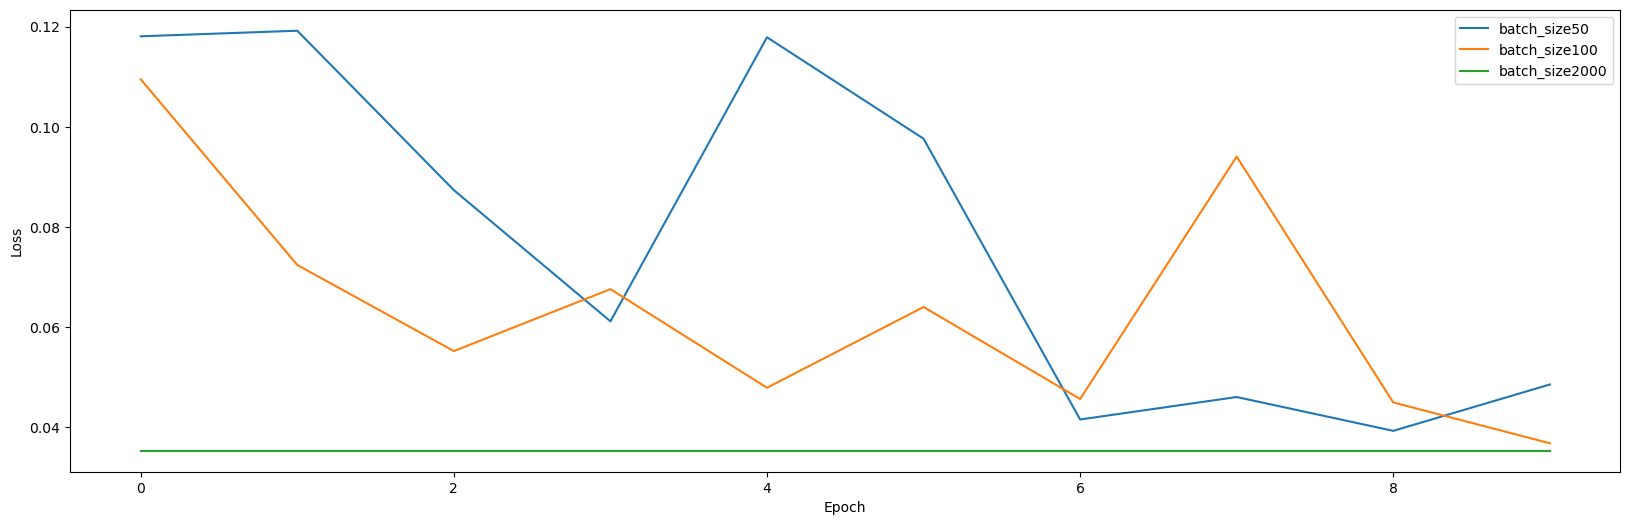

Results after 10 epochs:

Position 1: net3 - loss = 0.035
Position 2: net2 - loss = 0.037
Position 3: net1 - loss = 0.049


In [88]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist10_batch1,label='batch_size50')
plt.plot(loss_val_hist10_batch2,label='batch_size100')
plt.plot(loss_val_hist10_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,4):
    
    loss_val = globals().get(f'loss_val_hist10_batch{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

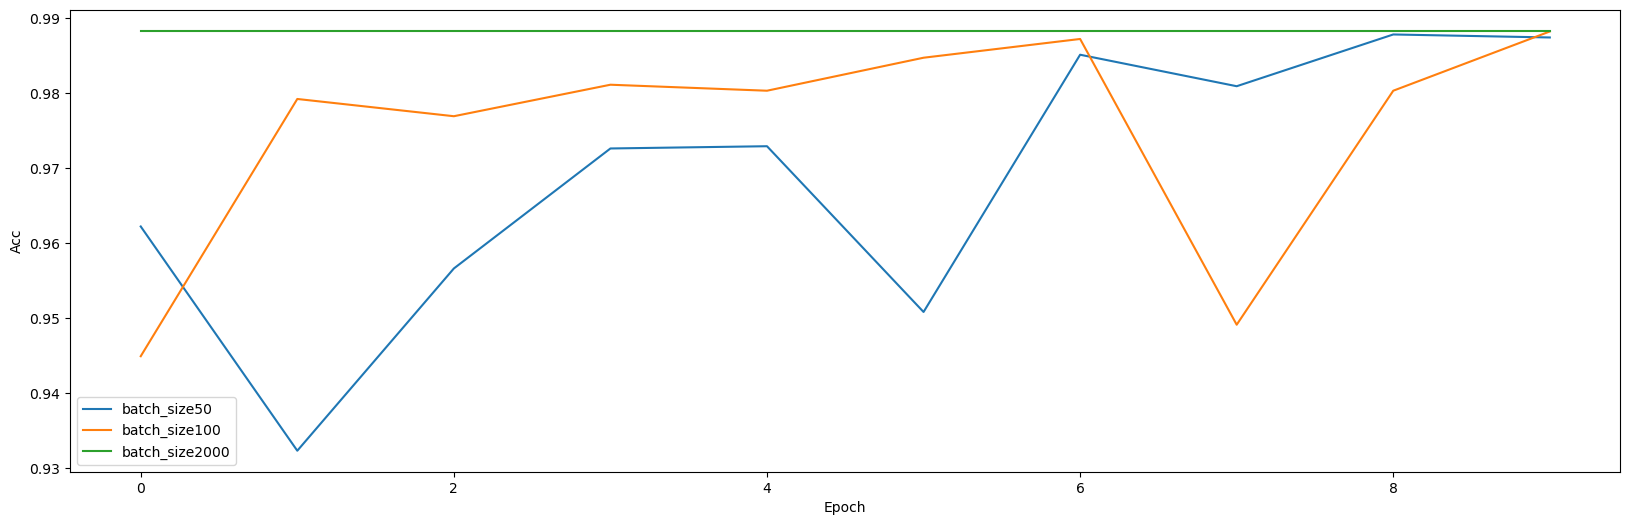

Results after 10 epochs:

Position 1: net3 - loss = 98.83%
Position 2: net2 - loss = 98.82%
Position 3: net1 - loss = 98.74%


In [89]:
# Plot Acc
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist10_batch1,label='batch_size50')
plt.plot(acc_val_hist10_batch2,label='batch_size100')
plt.plot(acc_val_hist10_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,4):
    
    acc_val = globals().get(f'acc_val_hist10_batch{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(acc_value*100,3)}%')